In [1]:
import numpy as np
import pandas as pd
import scipy, scipy.signal

from datetime import date
import time

from random import seed
from random import random

import os, os.path
import shutil

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import matplotlib
import matplotlib.pyplot as plt
from pylab import imshow

import h5py
import sys
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/NASA/Python_codes/')
import NASA_core as nc
# import NASA_plot_core.py as rcp

In [4]:
# Read Training Set Labels

In [3]:
training_set_dir = "/Users/hn/Documents/01_research_data/NASA/ML_data/"
ground_truth_labels = pd.read_csv(training_set_dir+"train_labels.csv")
print ("Unique Votes: ", ground_truth_labels.Vote.unique())
print (len(ground_truth_labels.ID.unique()))
ground_truth_labels.head(2)

Unique Votes:  [2 1]
1849


,ID,Vote
0,99837_WSDA_SF_2017,2
1,114615_WSDA_SF_2017,1


# Start VI images

In [6]:
VI_idx = "EVI"
data_dir = "/Users/hn/Documents/01_research_data/NASA/VI_TS/04_regularized_TS/"

In [7]:
file_names = ["regular_Walla2015_EVI_JFD.csv", "regular_AdamBenton2016_EVI_JFD.csv", 
              "regular_Grant2017_EVI_JFD.csv", "regular_FranklinYakima2018_EVI_JFD.csv"]

data=pd.DataFrame()

for file in file_names:
    curr_file=pd.read_csv(data_dir + file)
    curr_file['human_system_start_time'] = pd.to_datetime(curr_file['human_system_start_time'])
    
    # These data are for 3 years. The middle one is the correct one
    all_years = sorted(curr_file.human_system_start_time.dt.year.unique())
    if len(all_years)==3 or len(all_years)==2:
        proper_year = all_years[1]
    elif len(all_years)==1:
        proper_year = all_years[0]

    curr_file = curr_file[curr_file.human_system_start_time.dt.year==proper_year]
    data=pd.concat([data, curr_file])

data.reset_index(drop=True, inplace=True)
data.head(2)

,ID,human_system_start_time,EVI
0,135073_WSDA_SF_2015,2015-01-10,0.049624
1,135073_WSDA_SF_2015,2015-01-20,0.026503


### Pick up the fields whose "true" label we know

In [9]:
ID_list = list(ground_truth_labels.ID.unique())
ground_truth = data[data.ID.isin(ID_list)].copy()
ground_truth.reset_index(drop=True, inplace=True)

# Sort the order of time-series and experts' labels identically

In [11]:
ground_truth.sort_values(by=["ID", 'human_system_start_time'], inplace=True)
ground_truth_labels.sort_values(by=["ID"], inplace=True)

ground_truth.reset_index(drop=True, inplace=True)
ground_truth_labels.reset_index(drop=True, inplace=True)

assert (len(ground_truth.ID.unique()) == len(ground_truth_labels.ID.unique()))

print (list(ground_truth.ID)[0])
print (list(ground_truth_labels.ID)[0])
print ("____________________________________")
print (list(ground_truth.ID)[-1])
print (list(ground_truth_labels.ID)[-1])
print ("____________________________________")
print (list(ground_truth.ID.unique())==list(ground_truth_labels.ID.unique()))

100048_WSDA_SF_2017
100048_WSDA_SF_2017
____________________________________
99909_WSDA_SF_2017
99909_WSDA_SF_2017
____________________________________
True


# Form the Ratios

In [13]:
mins = ground_truth.groupby("ID")[VI_idx].min()
maxs = ground_truth.groupby("ID")[VI_idx].max()
_ranges = maxs-mins
_ranges = pd.DataFrame(_ranges)
_ranges.reset_index(inplace=True)

mins = pd.DataFrame(mins)
mins.reset_index(inplace=True)


_ranges.rename(columns = {'EVI':'EVI_range'}, inplace = True)
mins.rename(columns = {'EVI':'EVI_min'}, inplace = True)

_ranges.head(2)

,ID,EVI_range
0,100048_WSDA_SF_2017,0.602470
1,100081_WSDA_SF_2017,0.721754


In [14]:
ground_truth = pd.merge(ground_truth, _ranges, on=['ID'], how='left')
ground_truth = pd.merge(ground_truth, mins, on=['ID'], how='left')
ground_truth["EVI_ratio"] = (ground_truth["EVI"]-ground_truth["EVI_min"])/ground_truth["EVI_range"]
ground_truth.head(2)

,ID,human_system_start_time,EVI,EVI_range,EVI_min,EVI_ratio
0,100048_WSDA_SF_2017,2017-01-06,0.0,0.60247,0.0,0.0
1,100048_WSDA_SF_2017,2017-01-16,0.0,0.60247,0.0,0.0


In [17]:
ground_truth=ground_truth[["ID", "EVI_ratio"]]
ground_truth.rename(columns = {'EVI_ratio':'EVI'}, inplace = True)
ground_truth.head(2)

,ID,EVI
0,100048_WSDA_SF_2017,0.0
1,100048_WSDA_SF_2017,0.0


### Widen ground_truth

In [20]:
EVI_colnames = [VI_idx + "_" + str(ii) for ii in range(1, 37) ]
columnNames = ["ID"] + EVI_colnames
ground_truth_wide = pd.DataFrame(columns=columnNames, 
                             index=range(len(ground_truth.ID.unique())))
ground_truth_wide["ID"] = ground_truth.ID.unique()

for an_ID in ground_truth.ID.unique():
    curr_df = ground_truth[ground_truth.ID==an_ID]
    
    ground_truth_wide_indx = ground_truth_wide[ground_truth_wide.ID==an_ID].index
    ground_truth_wide.loc[ground_truth_wide_indx, "EVI_1":"EVI_36"] = curr_df.EVI.values[:36]
ground_truth_wide.head(2)

,ID,EVI_1,EVI_2,EVI_3,EVI_4,EVI_5,EVI_6,EVI_7,EVI_8,EVI_9,...,EVI_27,EVI_28,EVI_29,EVI_30,EVI_31,EVI_32,EVI_33,EVI_34,EVI_35,EVI_36
0,100048_WSDA_SF_2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.119885,0.14688,...,0.185084,0.198406,0.219895,0.101537,0.09269,0.083844,0.074997,0.06615,0.074966,0.083782
1,100081_WSDA_SF_2017,0.020551,0.231434,0.442317,0.6532,0.523936,0.394671,0.27498,0.402745,0.552051,...,0.134003,0.163373,0.220377,0.167899,0.083949,0.0,0.069282,0.138563,0.141695,0.144826


In [21]:
ground_truth_wide.head(2)

,ID,EVI_1,EVI_2,EVI_3,EVI_4,EVI_5,EVI_6,EVI_7,EVI_8,EVI_9,...,EVI_27,EVI_28,EVI_29,EVI_30,EVI_31,EVI_32,EVI_33,EVI_34,EVI_35,EVI_36
0,100048_WSDA_SF_2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.119885,0.14688,...,0.185084,0.198406,0.219895,0.101537,0.09269,0.083844,0.074997,0.06615,0.074966,0.083782
1,100081_WSDA_SF_2017,0.020551,0.231434,0.442317,0.6532,0.523936,0.394671,0.27498,0.402745,0.552051,...,0.134003,0.163373,0.220377,0.167899,0.083949,0.0,0.069282,0.138563,0.141695,0.144826


In [22]:
ground_truth_labels.head(2)

,ID,Vote
0,100048_WSDA_SF_2017,1
1,100081_WSDA_SF_2017,1


### Sort the order of time-series and experts' labels identically

In [24]:
ground_truth_wide.sort_values(by=["ID"], inplace=True)
ground_truth_labels.sort_values(by=["ID"], inplace=True)

ground_truth.reset_index(drop=True, inplace=True)
ground_truth_labels.reset_index(drop=True, inplace=True)

# ground_truth_labels = ground_truth_labels.set_index('ID')
# ground_truth_labels = ground_truth_labels.reindex(index=ground_truth_wide['ID'])
# ground_truth_labels = ground_truth_labels.reset_index()

(ground_truth_labels.ID==ground_truth_wide.ID).sum()

### Split

In [80]:
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(ground_truth_wide, 
                                                                ground_truth_labels, 
                                                                test_size=0.2, 
                                                                random_state=0,
                                                                shuffle=True)

In [81]:
print ((x_train_df.ID==y_train_df.ID).sum()==len(x_train_df.ID.unique()))
print ((x_test_df.ID==y_test_df.ID).sum()==len(y_test_df.ID.unique()))

True
True


In [82]:
# random_state is used for solver == ‘sag’, ‘saga’ or ‘liblinear’
logisticRegr = LogisticRegression(max_iter=100000, random_state=0); 
logisticRegr.fit(x_train_df.iloc[:, 1:], y_train_df.Vote.values);

prediction is [1].


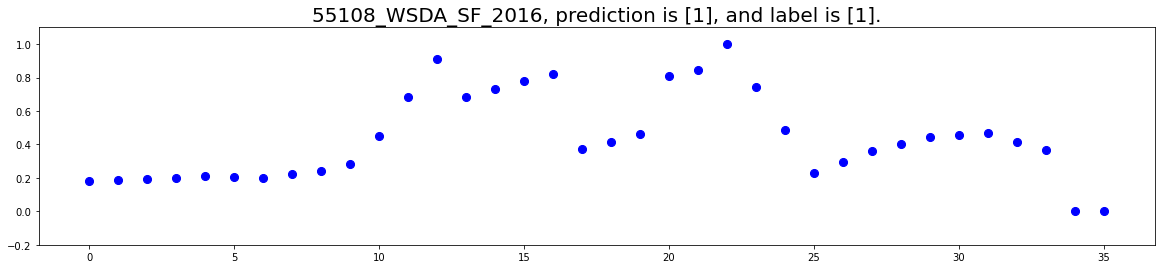

In [83]:
# Returns a NumPy Array
# Predict for One Observation (image)
test_index = 0
ID = x_test_df.iloc[test_index,].ID
prediction = logisticRegr.predict(x_test_df.iloc[test_index, 1:].values.reshape(1,-1))
print ("prediction is {}.".format(prediction))

######################################################
plt.figure(figsize=(20,4))
plt.subplot(1, 1, 1)

proper_index = x_test_df.index[test_index]
plt.scatter(range(len(x_test_df.loc[proper_index, "EVI_1":"EVI_36"])),
            x_test_df.loc[proper_index, "EVI_1":"EVI_36"].values,
            marker='o', s=65, c='b', label=VI_idx);
plt.ylim([-0.2, 1.1])

curr_V = str(y_test_df[y_test_df.ID == ID].Vote.values[0])
title = ID + ", prediction is " + str(prediction) + ", and label is [" + curr_V + "]."
plt.title(title , fontsize = 20);

In [84]:
confusion_table = pd.DataFrame(columns=['None', 'Predict_Single', 'Predict_Double'], index=range(2))
confusion_table.loc[0, 'None'] = 'Actual_Single'
confusion_table.loc[1, 'None'] = 'Actual_Double'
confusion_table['Predict_Single']=0
confusion_table['Predict_Double']=0

actual_double_predicted_single=[]

for integer_idx in range(len(x_test_df.index)):
    ID = x_test_df.iloc[integer_idx,].ID


    prediction = logisticRegr.predict(x_test_df.iloc[integer_idx, 1:].values.reshape(1,-1))
    prediction = prediction[0]
    curr_V = y_test_df[y_test_df.ID == ID].Vote.values[0]
    
    if prediction==curr_V==1:
        confusion_table.loc[0, "Predict_Single"]+=1
    elif prediction==curr_V==2:
        confusion_table.loc[1, "Predict_Double"]+=1
    
    elif prediction!=curr_V:
        if prediction==1:
            confusion_table.loc[1, "Predict_Single"]+=1
            actual_double_predicted_single += [ID]
        elif prediction==2:
            confusion_table.loc[0, "Predict_Double"]+=1
            

confusion_table

,None,Predict_Single,Predict_Double
0,Actual_Single,306,6
1,Actual_Double,25,33


### Stratify split

In [85]:
A = x_train_df.copy()

In [86]:
# split the train and test set randomly
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(ground_truth_wide, 
                                                                ground_truth_labels, 
                                                                test_size=0.2, 
                                                                random_state=0,
                                                                shuffle=True,
                                                                stratify=ground_truth_labels.Vote.values)

In [87]:
sorted(A.ID)==sorted(x_train_df.ID)

False

In [88]:
# random_state is used for solver == ‘sag’, ‘saga’ or ‘liblinear’
logisticRegr_stratified = LogisticRegression(max_iter=100000, random_state=0); 
logisticRegr_stratified.fit(x_train_df.iloc[:, 1:], y_train_df.Vote.values);

In [89]:
confusion_table = pd.DataFrame(columns=['None', 'Predict_Single', 'Predict_Double'], index=range(2))
confusion_table.loc[0, 'None'] = 'Actual_Single'
confusion_table.loc[1, 'None'] = 'Actual_Double'
confusion_table['Predict_Single']=0
confusion_table['Predict_Double']=0

actual_double_predicted_single=[]

for integer_idx in range(len(x_test_df.index)):
    ID = x_test_df.iloc[integer_idx,].ID


    prediction = logisticRegr_stratified.predict(x_test_df.iloc[integer_idx, 1:].values.reshape(1,-1))
    prediction = prediction[0]
    curr_V = y_test_df[y_test_df.ID == ID].Vote.values[0]
    
    if prediction==curr_V==1:
        confusion_table.loc[0, "Predict_Single"]+=1
    elif prediction==curr_V==2:
        confusion_table.loc[1, "Predict_Double"]+=1
    
    elif prediction!=curr_V:
        if prediction==1:
            confusion_table.loc[1, "Predict_Single"]+=1
            actual_double_predicted_single += [ID]
        elif prediction==2:
            confusion_table.loc[0, "Predict_Double"]+=1
            

confusion_table

,None,Predict_Single,Predict_Double
0,Actual_Single,306,6
1,Actual_Double,25,33
